# Wine Quality - Principal Component Analysis

## Introduction

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a set of possibly correlated features into a smaller number of uncorrelated components, called principal components. Each component is a linear combination of the original features and captures the maximum possible variance in the data.

In this project, PCA helps by:

Reducing multicollinearity between highly correlated features (e.g., residual sugar, density, alcohol).

Simplifying the dataset while retaining most of the important variance.

Improving model performance and interpretability, especially for linear regression models that are sensitive to correlated predictors.

By projecting the data into fewer dimensions, PCA allows us to test whether regression models can achieve similar or better predictive performance with a smaller set of features.

In [3]:
### Load relevant packages
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
import statsmodels.api         as sm
from sklearn.decomposition     import PCA
from sklearn                   import preprocessing
from sklearn.preprocessing     import StandardScaler
from sklearn.linear_model      import LinearRegression
from sklearn.model_selection   import train_test_split
from sklearn.metrics           import mean_squared_error, r2_score, mean_absolute_error

## Load the dataset

In [4]:
wine_quality = pd.read_csv("../data/winequality-white.csv",sep=';')
# Step for converting white space in columns to _ value for better handling
wine_quality.rename(columns=lambda x: x.replace(" ", "_"), inplace=True)

Mounted at /content/drive


In [7]:
wine_quality.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Scale the data to work better with PCA

In [8]:
features = ['fixed_acidity',
            'volatile_acidity',
            'citric_acid',
            'residual_sugar',
            'chlorides',
            'free_sulfur_dioxide',
            'total_sulfur_dioxide',
            'density',
            'pH',
            'sulphates',
            'alcohol']

X = wine_quality.loc[:, features].values

y = wine_quality.loc[:, ['quality']].values

X = StandardScaler().fit_transform(X)

Split the dataset

In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Choosing the number of Principal Components

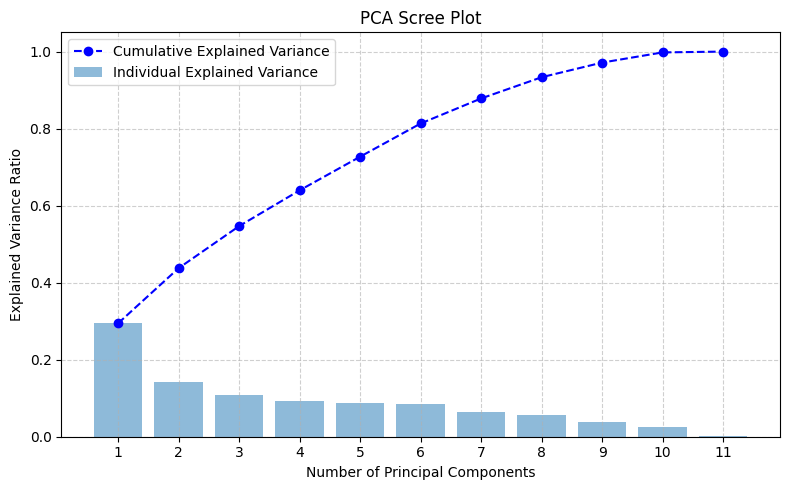

In [11]:
# Fit PCA with all components
pca = PCA(n_components=None, random_state=42)
pca.fit(X_train)

# Explained variance for each PC
evr = pca.explained_variance_ratio_

# Cumulative explained variance
cum_evr = np.cumsum(evr)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(evr)+1), cum_evr, marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')
plt.bar(range(1, len(evr)+1), evr, alpha=0.5, align='center', label='Individual Explained Variance')

plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.xticks(range(1, len(evr)+1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

*Interpretation*

Bars (light blue) → Individual Explained Variance

Each bar represents how much variance a single principal component explains.

PC1 explains ~30% of variance, PC2 ~14%, PC3 ~11%, etc.

After the first few components, each one contributes less and less variance.

---

*Blue Line (dashed with dots) → Cumulative Explained Variance*

Shows how much total variance is explained as you add more components.

Starts at ~30% with PC1, ~55% by PC3, ~80% by PC6, and ~95% by PC8.

By PC10–11, nearly 100% variance is captured.

---

*The “Elbow” Point*

Scree plots are read by looking for the “elbow” (point of diminishing returns).

In this plot, the elbow is around PC5–6: after that, adding more components increases variance explained only slightly.

According to Dangeti (2017), there are two common methods to determine the appropriate number of principal components:

Method 1: Choose the number of PCs based on the point of diminishing marginal improvement in variance explained (the “elbow method”).

Method 2: Choose the number of PCs such that the cumulative variance explained exceeds 80%.

From the scree plot above, we observe that the cumulative variance explained surpasses 80% when using 6 principal components. Method 1 is less suitable in this case, since the improvement in variance explained decreases gradually and no clear elbow point is observed.

PCA + OLS Regression Model

In [14]:
# --- Step 1: Apply PCA with n=6 on scaled training data ---
pca = PCA(n_components=6, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# --- Step 2: Add constant term for OLS (intercept) ---
X_train_pca_const = sm.add_constant(X_train_pca)
X_test_pca_const = sm.add_constant(X_test_pca)

# --- Step 3: Fit OLS model ---
ols_model = sm.OLS(y_train, X_train_pca_const).fit()

# --- Step 4: Make predictions ---
y_pred = ols_model.predict(X_test_pca_const)

# --- Step 5: Evaluate model ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
y_avg = y.mean()

print("OLS Regression Results with PCA (n=6):")
print(ols_model.summary())
print("\ny average:", y_avg)
print("Mean Squared Error (MSE):", mse)
print("SQRT MSE:", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

OLS Regression Results with PCA (n=6):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.179
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sat, 06 Sep 2025   Prob (F-statistic):          1.34e-143
Time:                        19:55:02   Log-Likelihood:                -4108.8
No. Observations:                3428   AIC:                             8232.
Df Residuals:                    3421   BIC:                             8275.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

Model Diagnostics

1. Checks target distribution.

2. Inspects error distribution.

3. Detects patterns/bias in residuals.

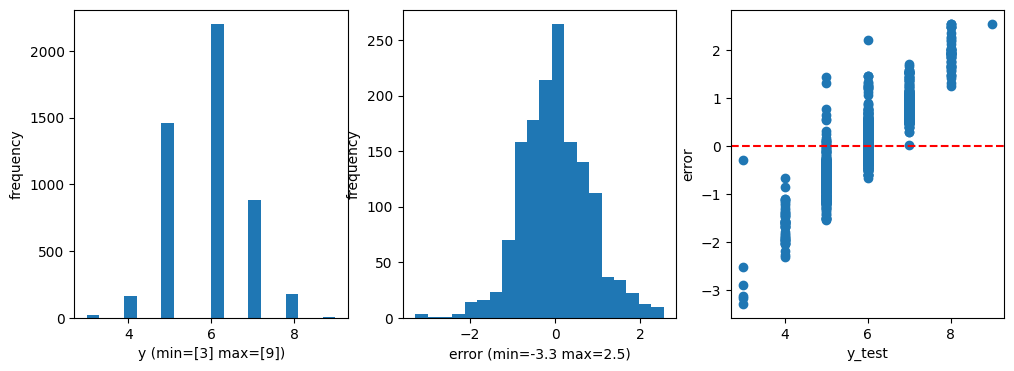

In [18]:
error = y_test.ravel() - y_pred.ravel()
fig, axes = plt.subplots(1, 3, figsize=(12,4))

#Distribution of Target (y)
plt.subplot(1,3,1)
plt.hist(y, bins=20)
plt.xlabel(f"y (min={min(y)} max={max(y)})")
plt.ylabel("frequency")

#Distribution of Errors (Residuals)
plt.subplot(1,3,2)
plt.hist(error, bins=20)
plt.xlabel(f"error (min={min(error):.2} max={max(error):.2})")
plt.ylabel("frequency")

#Residuals vs Actual Values
plt.subplot(1,3,3)
plt.scatter(y_test.ravel(), error)
plt.xlabel("y_test")
plt.ylabel("error")
plt.axhline(y=0.0, color='r', linestyle='dashed')
plt.show()

The model learns the middle well (5–6) but struggles with extremes (low-quality and high-quality wines).

This is a direct result of the class imbalance in the target variable.

Errors are fairly symmetric, but the spread shows that predictions are not very sharp.

Applying Transformation

In [38]:
# Make a copy of the existing dataset
wine_quality_modified = wine_quality.copy()

# Apply data transformation to correct skewness
wine_quality_modified['fixed_acidity'] = np.log(wine_quality_modified['fixed_acidity'])
wine_quality_modified['volatile_acidity'] = np.cbrt(wine_quality_modified['volatile_acidity'])
wine_quality_modified['citric_acid'] = np.sqrt(wine_quality_modified['citric_acid'])
wine_quality_modified['residual_sugar'] = np.cbrt(wine_quality_modified['residual_sugar'])
wine_quality_modified['chlorides'] = np.cbrt(wine_quality_modified['chlorides'])
wine_quality_modified['free_sulfur_dioxide'] = np.log(wine_quality_modified['free_sulfur_dioxide'])
wine_quality_modified['total_sulfur_dioxide'] = np.sqrt(wine_quality_modified['total_sulfur_dioxide'])
#wine_quality_modified.drop(columns=['density'], inplace=True) # Drop columns since data correction was not found. Also it displays high correlation with other two variables
wine_quality_modified['pH'] = 1/np.sqrt(wine_quality_modified['pH'])
wine_quality_modified['sulphates'] = 1/np.cbrt(wine_quality_modified['sulphates'])
wine_quality_modified['alcohol'] = 1/(wine_quality_modified['alcohol'])

In [42]:
#density has been removed
features = ['fixed_acidity',
            'volatile_acidity',
            'citric_acid',
            'residual_sugar',
            'chlorides',
            'free_sulfur_dioxide',
            'total_sulfur_dioxide',
            'pH',
            'sulphates',
            'alcohol']

X = wine_quality_modified.loc[:, features].values

y = wine_quality_modified.loc[:, ['quality']].values

X = StandardScaler().fit_transform(X)

Split the dataset

In [45]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

Choosing the number of Principal Components after Transformation

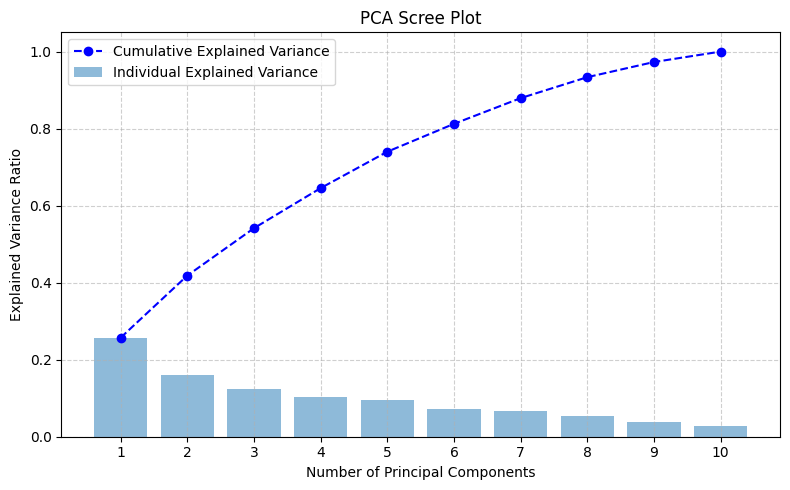

In [46]:
# Fit PCA with all components
pca = PCA(n_components=None, random_state=42)
pca.fit(X_train)

# Explained variance for each PC
evr = pca.explained_variance_ratio_

# Cumulative explained variance
cum_evr = np.cumsum(evr)

# Plot
plt.figure(figsize=(8,5))
plt.plot(range(1, len(evr)+1), cum_evr, marker='o', linestyle='--', color='b', label='Cumulative Explained Variance')
plt.bar(range(1, len(evr)+1), evr, alpha=0.5, align='center', label='Individual Explained Variance')

plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.xticks(range(1, len(evr)+1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Even after transforming the data, using 6 Principal Components provides better explainability, capturing more than 80% of the total variance.

In [47]:
# --- Step 1: Apply PCA with n=6 on scaled training data ---
pca = PCA(n_components=6, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# --- Step 2: Add constant term for OLS (intercept) ---
X_train_pca_const = sm.add_constant(X_train_pca)
X_test_pca_const = sm.add_constant(X_test_pca)

# --- Step 3: Fit OLS model ---
ols_model = sm.OLS(y_train, X_train_pca_const).fit()

# --- Step 4: Make predictions ---
y_pred = ols_model.predict(X_test_pca_const)

# --- Step 5: Evaluate model ---
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test,y_pred)
y_avg = y.mean()

print("OLS Regression Results with PCA (n=6):")
print(ols_model.summary())
print("\ny average:", y_avg)
print("Mean Squared Error (MSE):", mse)
print("SQRT MSE:", np.sqrt(mse))
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)

OLS Regression Results with PCA (n=6):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     151.9
Date:                Sat, 06 Sep 2025   Prob (F-statistic):          2.17e-171
Time:                        20:44:39   Log-Likelihood:                -4044.4
No. Observations:                3428   AIC:                             8103.
Df Residuals:                    3421   BIC:                             8146.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

### Comparing results from Before and AFter Transformation of the dataset

y average (≈ 5.88) → unchanged, as expected.

MSE → decreased slightly (0.648 → 0.629) → better fit.

RMSE → also improved (0.805 → 0.793) → predictions closer to true values on average.

MAE → reduced (0.618 → 0.610) → smaller absolute deviations.

R² → improved from 0.172 → 0.196, meaning the model now explains a slightly higher proportion of variance in wine quality.

After applying transformations, the PCA + OLS regression model shows modest improvements across all performance metrics: MSE, RMSE, and MAE decrease, while R² increases. This indicates that the transformed features provide a slightly better explanatory fit compared to the original data.